<h1 style="font-family:Impact,Arial;font-size:50px">Load SQL</h1>
<p> This code loads the raw data from the VAST database. It uses a PSQL connection to pull the raw tables and columns, it then joins and converts the tables to usable format in Pandas in conjunction with the scripts in git. 

In [5]:
import math
import pandas as pd
import numpy as np
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib.pyplot as plt

In [2]:
# get connected to the database
connection = pg.connect("dbname=postgres user=postgres password=sqg4179eq")

In [3]:
%%time
image_table = psql.read_sql("SELECT id, rms, time, jd, cube_id, ra, dec, name FROM vast_image", connection)
image_table.columns = (['image_id', 'rms', 'time', 'jd', 'cube_id', 'im_ra', 'im_dec', 'image'])

CPU times: user 161 ms, sys: 47.6 ms, total: 209 ms
Wall time: 499 ms


In [4]:
%%time
dataframe = psql.read_sql('SELECT id, source_id, image_id, good_fit, ra, err_ra, dec, err_dec, bmaj, bmin, pa, raw_total_flux, err_raw_total_flux, raw_peak_flux, err_raw_peak_flux, rms_background FROM vast_flux', connection)

CPU times: user 2min 53s, sys: 5min 20s, total: 8min 14s
Wall time: 17min 9s


In [5]:
%%time
raw_data = (pd.merge(dataframe, image_table, left_on='image_id', right_on='image_id'))

CPU times: user 15.1 s, sys: 10.8 s, total: 25.8 s
Wall time: 30.1 s


In [6]:
def vectorized_distance_on_unit_sphere(df):
    degrees_to_radians = np.pi/180.0
    phi1 = df.dec*degrees_to_radians
    phi2 = df.im_dec*degrees_to_radians

    theta1 = df.ra*degrees_to_radians
    theta2 = df.im_ra*degrees_to_radians
    
    cosine = (np.cos(phi1)*np.cos(phi2)*np.cos(theta1 - theta2) +
           np.sin(phi1)*np.sin(phi2))
    dist_from_centre = np.arccos(cosine)
    return (dist_from_centre/3.142)*180

## Conversions

In [7]:
raw_data['raw_peak_flux'] = raw_data['raw_peak_flux']*(1.0/1000.0) # Conversion to Jy
raw_data['err_raw_peak_flux'] = raw_data['err_raw_peak_flux']*(1.0/1000.0) # Conversion to Jy
raw_data['datetime'] = pd.to_datetime(raw_data.time, utc=True)

## Calculate the distance between the source and the image centre ( then create column)

In [8]:
%%time
raw_data['distance'] = vectorized_distance_on_unit_sphere(raw_data)

CPU times: user 1.77 s, sys: 2.5 s, total: 4.27 s
Wall time: 2.88 s


## Add in the gains to the data file

In [9]:
raw_data["image"]= raw_data["image"].str.split("[").str.get(0) 

In [10]:
%%time
gains = pd.read_table('../all_gains.txt', ',')
raw_data = pd.merge(raw_data, gains, left_on='image', right_on='Image')

CPU times: user 13.5 s, sys: 20 s, total: 33.5 s
Wall time: 55 s


In [11]:
raw_data = raw_data.drop('Image', 1)

## Filter good fits only

In [12]:
raw_data = raw_data[raw_data.good_fit == True]

## Save the reduced data file

In [13]:
%%time
raw_data= raw_data.reset_index()
raw_data.to_feather('mwats_raw_data_Apr_SQL.fth')

CPU times: user 10.9 s, sys: 29.2 s, total: 40.2 s
Wall time: 50.7 s


# Make some plots for the paper

In [37]:
rms = image_table.rms

In [18]:
rms = rms[rms< 1000]

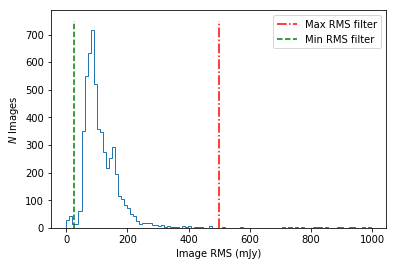

In [34]:
plt.hist(rms, bins=100, histtype='step')
plt.plot([500, 500],[0,750], 'r-.', label='Max RMS filter')
plt.plot([25, 25],[0,750], 'g--', label='Min RMS filter')
plt.legend()
plt.xlabel('Image RMS (mJy)')
plt.ylabel('$N$ Images')
plt.savefig('figures/rms.eps')

In [ ]:
rms = rms[rms< 500]

In [35]:
rms = rms[rms> 25]

In [38]:
rms.mean()

254.26649203528936